<a href="https://colab.research.google.com/github/sholtodouglas/artificial_graphics/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install git+https://github.com/deepmind/dm-haiku
!pip install wandb -q
!pip install pathy -q
!pip install natsorted -q
!pip install dall-e -q

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-0neu7hy1
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-0neu7hy1
  Created wheel for dm-haiku: filename=dm_haiku-0.0.5.dev0-cp37-none-any.whl size=552722 sha256=fa82cd7fa807727dd5a6b8dab326a78cc4c7892d33384acbaed73f2c512caf7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-gof4925v/wheels/97/0f/e9/17f34e377f8d4060fa88a7e82bee5d8afbf7972384768a5499
Successfully built dm-haiku
ERROR: Could not find a version that satisfies the requirement natsorted (from versions: none)
ERROR: No matching distribution found for natsorted
     |████████████████████████████████| 21.6MB 92.8MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 747kB 61.5MB/s 
     |████████████████████████████████| 1.9MB 63.9MB/s 
ERROR: blobfile 1.2.0 has requirement urllib3~=1.25, but you'll have urllib3 1.24.3 which is incompatible.


In [2]:
import argparse
from natsort import natsorted

parser = argparse.ArgumentParser(description='AG training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=128, type=int)
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP

### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset train
--test_dataset test
-c
-s DRIVE
--bucket_name iowa_bucket_lfp
'''.split())



In [3]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/artificial_graphics')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/artificial_graphics' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to artificial_graphics
os.chdir(WORKING_PATH)
import lib

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/artificial_graphics')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
Cloning into '/content/artificial_graphics'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 65 (delta 25), reused 42 (delta 13), pack-reused 0
Unpacking objects: 100% (65/65), done.
Mounted at /content/drive
Reading data from Google Drive
Storage path: /content/drive/My Drive/artificial_graphics


In [141]:
if args.colab:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  raise NotImplementedError

DEVICES = jax.devices()
NUM_DEVICS = len(DEVICES)

In [136]:
!git pull
from importlib import reload
reload(lib.data)

Already up to date.


<module 'lib.data' from '/content/artificial_graphics/lib/data.py'>

In [87]:
  
import io

import jax
import requests
import PIL
from PIL import ImageOps

import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap
from jax import random

from lib.dall_e_jax import get_encoder, get_decoder, map_pixels, unmap_pixels, download_image

import matplotlib.pyplot as plt



target_image_size = 256


jax_enc_fn, jax_enc_params = get_encoder(str(STORAGE_PATH/'saved_models/') + "/encoder.pkl")
jax_dec_fn, jax_dec_params = get_decoder(str(STORAGE_PATH/'saved_models/') + "/decoder.pkl")

In [215]:



@jit
def preprocess_batch(b: dict, logit_laplace_eps = 0.1) -> dict:
  imgs = b['img']/255.0
  b['img'] = jnp.transpose(imgs, axes = [0, 3, 1, 2])
  b['img'] = (1 - 2 * logit_laplace_eps) * b['img'] + logit_laplace_eps
  return b




In [207]:
from lib.data import dataloader
import tensorflow_datasets as tfds

train_dl = dataloader(TRAIN_DATA_PATHS[0], batch_size = 128) # to make this distributed, pass num devices so we get an 8 ways batch - and then pmap it
train_dataset = iter(tfds.as_numpy(train_dl.dataset))


In [236]:
b = next(train_dataset)
b = jax.device_put(b, DEVICES[0])
b = preprocess_batch(b)

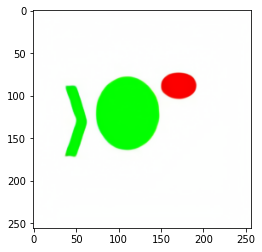

In [241]:
#@title Test recon
x = b['img'][0][jnp.newaxis]
z_logits = jax_enc_fn(jax_enc_params, x)
z = jnp.argmax(z_logits, axis=1)
z = jnp.transpose(jax.nn.one_hot(z, num_classes=8192), (0, 3, 1, 2))
B, D, H, W = z.shape
#z = jnp.reshape(jnp.repeat(jnp.reshape(z, (B, D, H*W))[:,:,::2], 2, axis = -1), (B,D,H,W))
x_stats = jax_dec_fn(jax_dec_params, z)
x_rec = unmap_pixels(jax.nn.sigmoid(x_stats[:, :3]))
x_rec = np.transpose((np.array(x_rec[0]) * 255).astype(np.uint8), (1, 2, 0))
plt.imshow(x_rec)